In [9]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [18]:
data15 = pd.read_csv("~/Documents/Data/NNRB/finaldata/Batch1thetatau.csv")
data15.head()

,Time,Temp
0,0,77.40651
1,10,81.71672
2,20,88.27853
3,30,92.03464
4,40,95.95712


<Axes: xlabel='Time'>

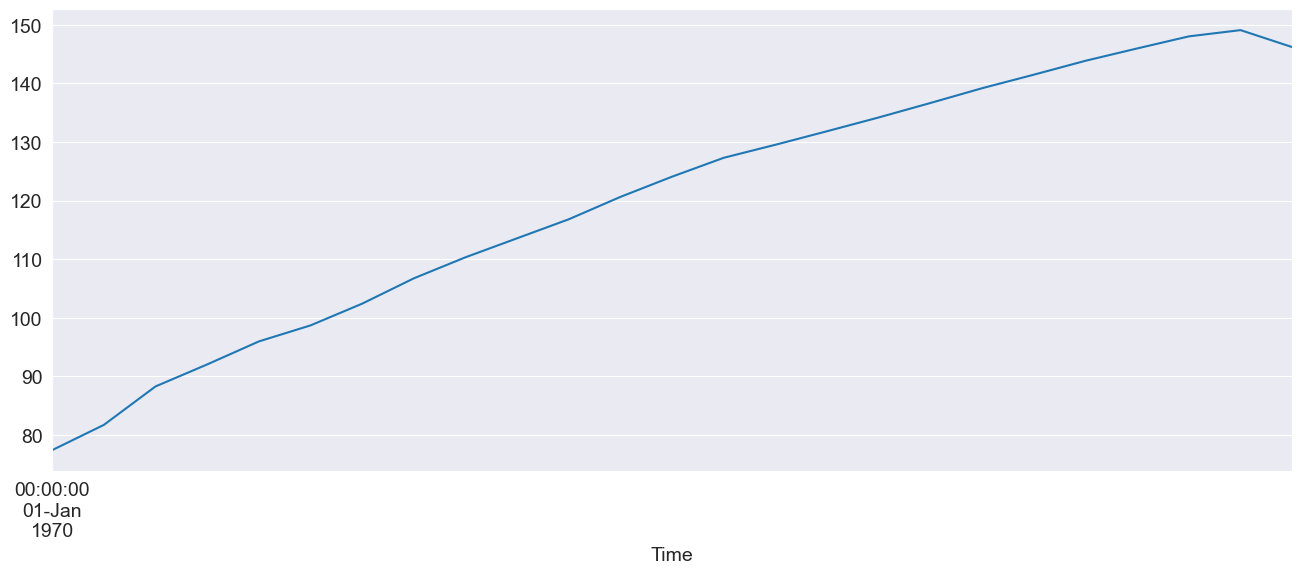

In [5]:
data15.Temp.plot()

## QQ Plot

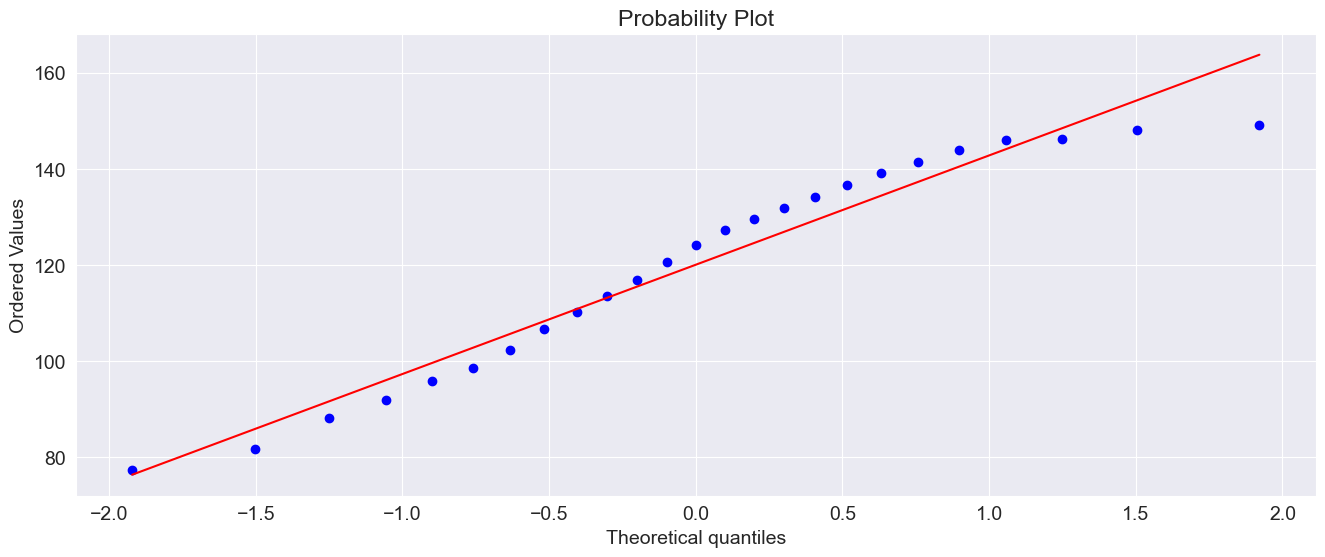

In [10]:
scipy.stats.probplot(data15.Temp, plot=pylab)
pylab.show()

In [13]:
data15.Time.describe()

count     25.000000
mean     120.000000
std       73.598007
min        0.000000
25%       60.000000
50%      120.000000
75%      180.000000
max      240.000000
Name: Time, dtype: float64

In [19]:
data15['Time'] = pd.to_datetime(data15['Time'], unit='m')
data15['Time'] = data15['Time'].dt.minute
data15.head()

,Time,Temp
0,0,77.40651
1,10,81.71672
2,20,88.27853
3,30,92.03464
4,40,95.95712


### Stationarity

In [4]:
sts.adfuller(data15.Dig_15_HX)

(-7.543803689298378,
 3.324234621154666e-11,
 18,
 2190,
 {'1%': -3.43333948922474,
  '5%': -2.8628606583021843,
  '10%': -2.5674730514376263},
 11594.303417514946)

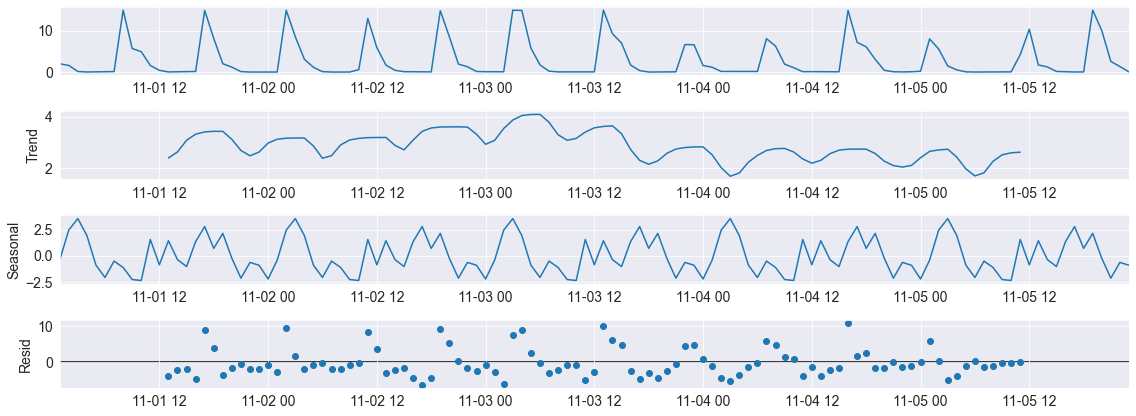

In [5]:
seas_dec = seasonal_decompose(data15[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

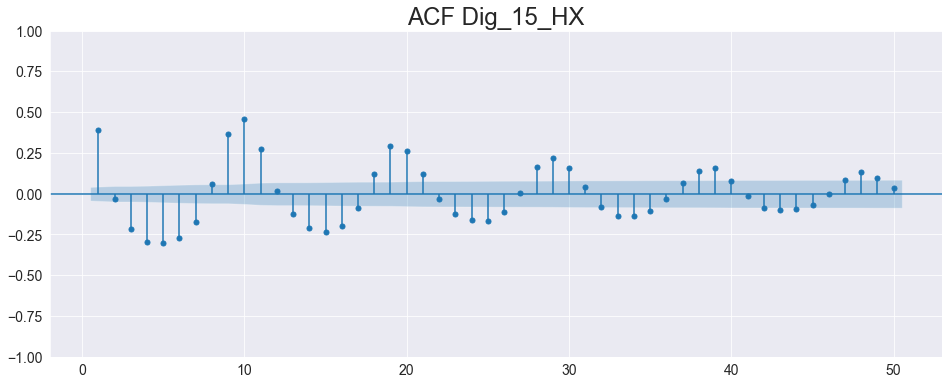

In [6]:
sgt.plot_acf(data15.Dig_15_HX, lags = 50, zero = False)
plt.title("ACF Dig_15_HX", size = 24)
plt.show()

### PACF

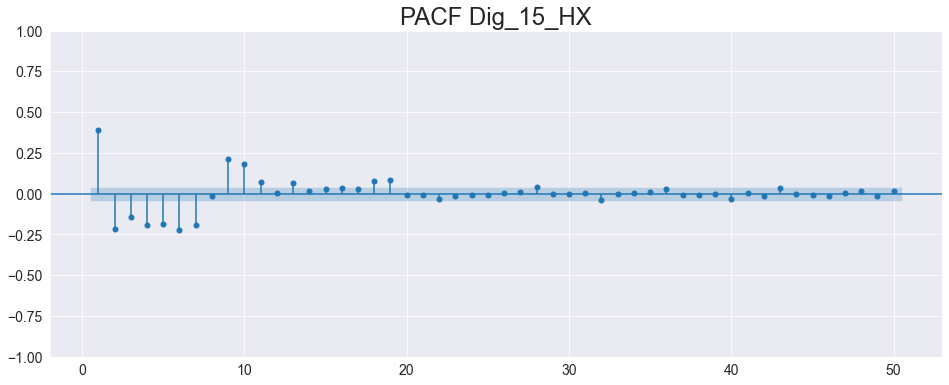

In [7]:
sgt.plot_pacf(data15.Dig_15_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_15_HX", size = 24)
plt.show()

In [8]:
#  Spare copy
data15_twin1 = data15.copy()

### Normalization

In [9]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [10]:
scaler = MinMaxScaler()
data15_twin = data15.copy()
scale_data(data15_twin, scaler)

,Dig_15_HX
Timestamp,
2020-11-01 00:00:00,0.619544
2020-11-01 01:00:00,0.132829
2020-11-01 02:00:00,0.107608
2020-11-01 03:00:00,0.009129
2020-11-01 04:00:00,0.001085


### Data Split

In [11]:
train_size = int(len(data15_twin)*0.85)
val_size = train_size + int(len(data15_twin)*0.10)
train_data15 = data15_twin.iloc[:train_size]
val_data15 = data15_twin.iloc[train_size:val_size]
test_data15 = data15_twin.iloc[val_size:]

In [12]:
val_data15.head()

,Dig_15_HX
Timestamp,
2021-01-18 05:00:00,0.920106
2021-01-18 06:00:00,0.442640
2021-01-18 07:00:00,0.146077
2021-01-18 08:00:00,0.041828
2021-01-18 09:00:00,0.007551


### Auto ARIMA Model

In [13]:
model_auto = auto_arima(train_data15.Dig_15_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [14]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(7, 0, 0)   Log Likelihood                  18.493
Date:                Tue, 03 May 2022   AIC                            -16.986
Time:                        11:43:34   BIC                             38.389
Sample:                             0   HQIC                             3.412
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3174      0.015     20.870      0.000       0.288       0.347
drift      -1.846e-05   1.02e-05     -1.810      0.070   -3.85e-05    1.53e-06
ar.L1          0.2737      0.025     10.807      0.000       0.224       0.323
ar.L2         -0.2299      0.036     -6.392      0.000      -0.300      -0.159
ar.L3         -0.1519      0.078     -1.936      0.053      -0.306       0.002
ar.L4         -0.1804      0.091     -1.973      0.048      -0.360      -0.001
ar.L5         -0.1528      0.088     -1.736      0.083      -0.325       0.020
ar.L6         -0.1637      0.080     -2.049      0.040      -0.320      -0.007
ar.L7         -0.1991      0.044     -4.553      0.000      -0.285      -0.113
sigma2         0.0575      0.002     29.608      0.000       0.054       0.061
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1583.95
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             1.68
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [15]:
data15_resid_dataset = train_data15.copy()
data15_resid_dataset['residuals'] = model_auto.resid()

In [16]:
print(data15_resid_dataset.residuals.mean())
print(data15_resid_dataset.residuals.var())

0.00011572343264961498
0.057439714070920266


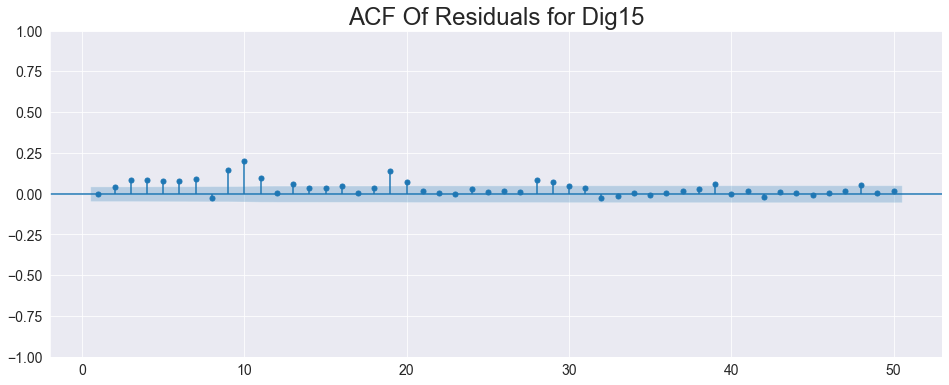

In [17]:
sgt.plot_acf(data15_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig15",size=24)
plt.show()

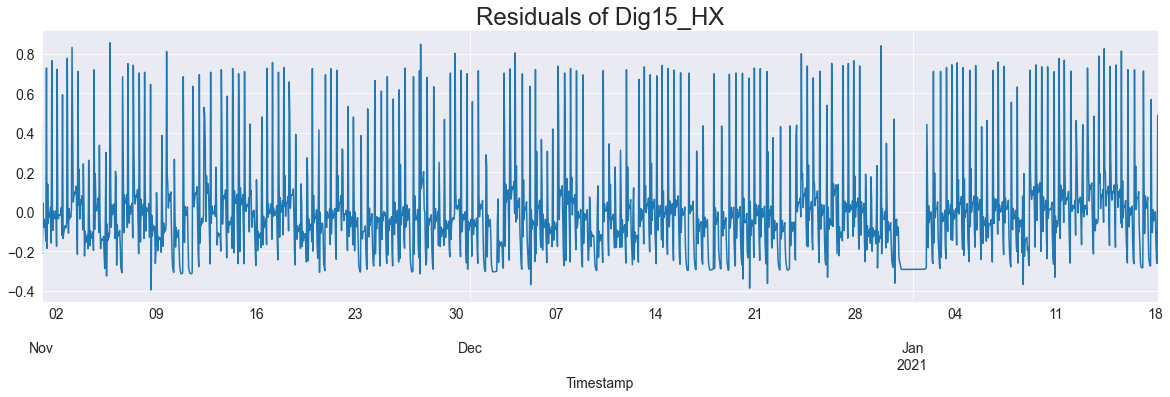

In [18]:
data15_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig15_HX",size=24)
plt.show()

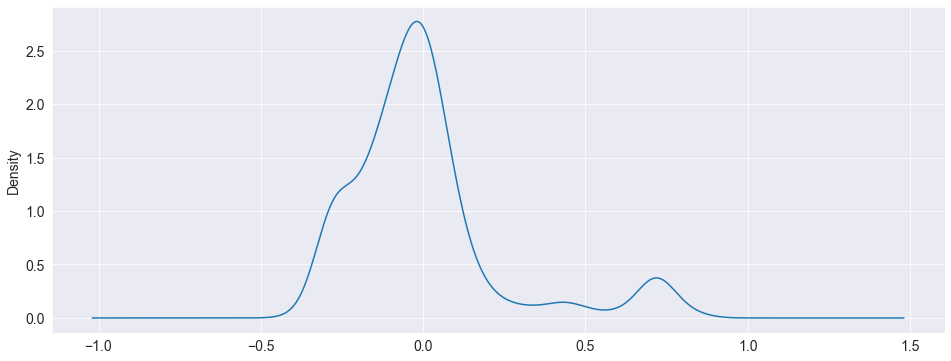

In [19]:
data15_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [20]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [21]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data15), index = val_data15.index))

In [22]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data15_twin1.Dig_15_HX.values.reshape(-1, 1))

array([[0.61954371],
       [0.132829  ],
       [0.10760794],
       ...,
       [0.00225712],
       [0.00261171],
       [0.0029663 ]])

In [23]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

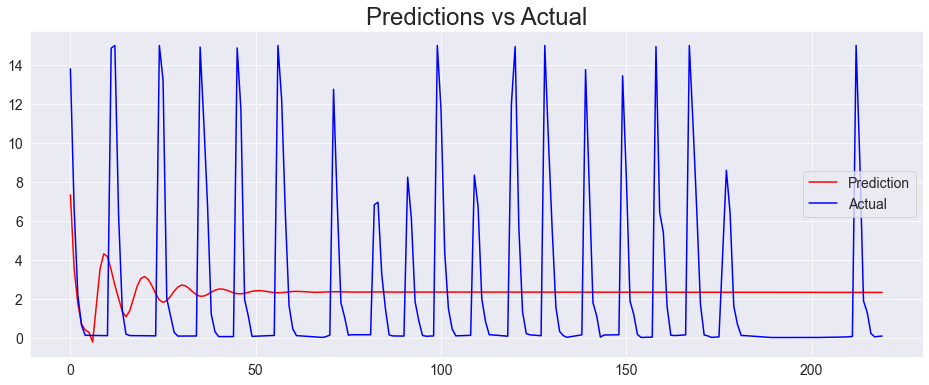

In [24]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data15_twin1.Dig_15_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [25]:
ndapred, ndaactual = df_pred, val_data15.Dig_15_HX.to_numpy()

In [26]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [27]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.2153
RMSE: 0.2934


In [28]:
np.save("C:/Users/USER/Documents/PythonModels/Hourly/Linear/Composite predictions/Dig15pred.npy", df_pred2)

### Forecast

In [29]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data15), index = test_data15.index))

In [30]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

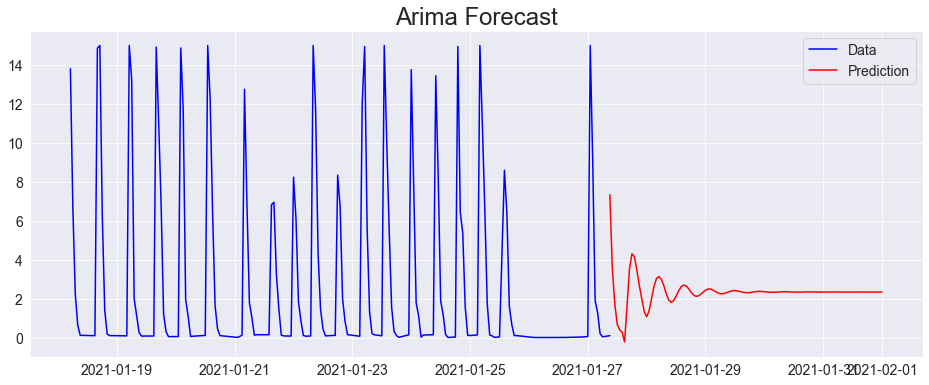

In [31]:
plt.plot(data15_twin1.index[1877:2098], data15_twin1.Dig_15_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data15.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [32]:
np.save("C:/Users/USER/Documents/PythonModels/Hourly/Linear/Composite predictions/Dig15fcast.npy", fcast)